In [289]:
import numpy as np
from functools import reduce
from astropy.io import fits
from astropy.modeling import models, fitting, Fittable1DModel
import matplotlib.pyplot as plt
import scipy.optimize as opt;
from astropy.modeling import Parameter
from photutils.isophote import Ellipse, EllipseGeometry, build_ellipse_model
from scipy.ndimage import gaussian_filter

In [290]:
file="NGC720"

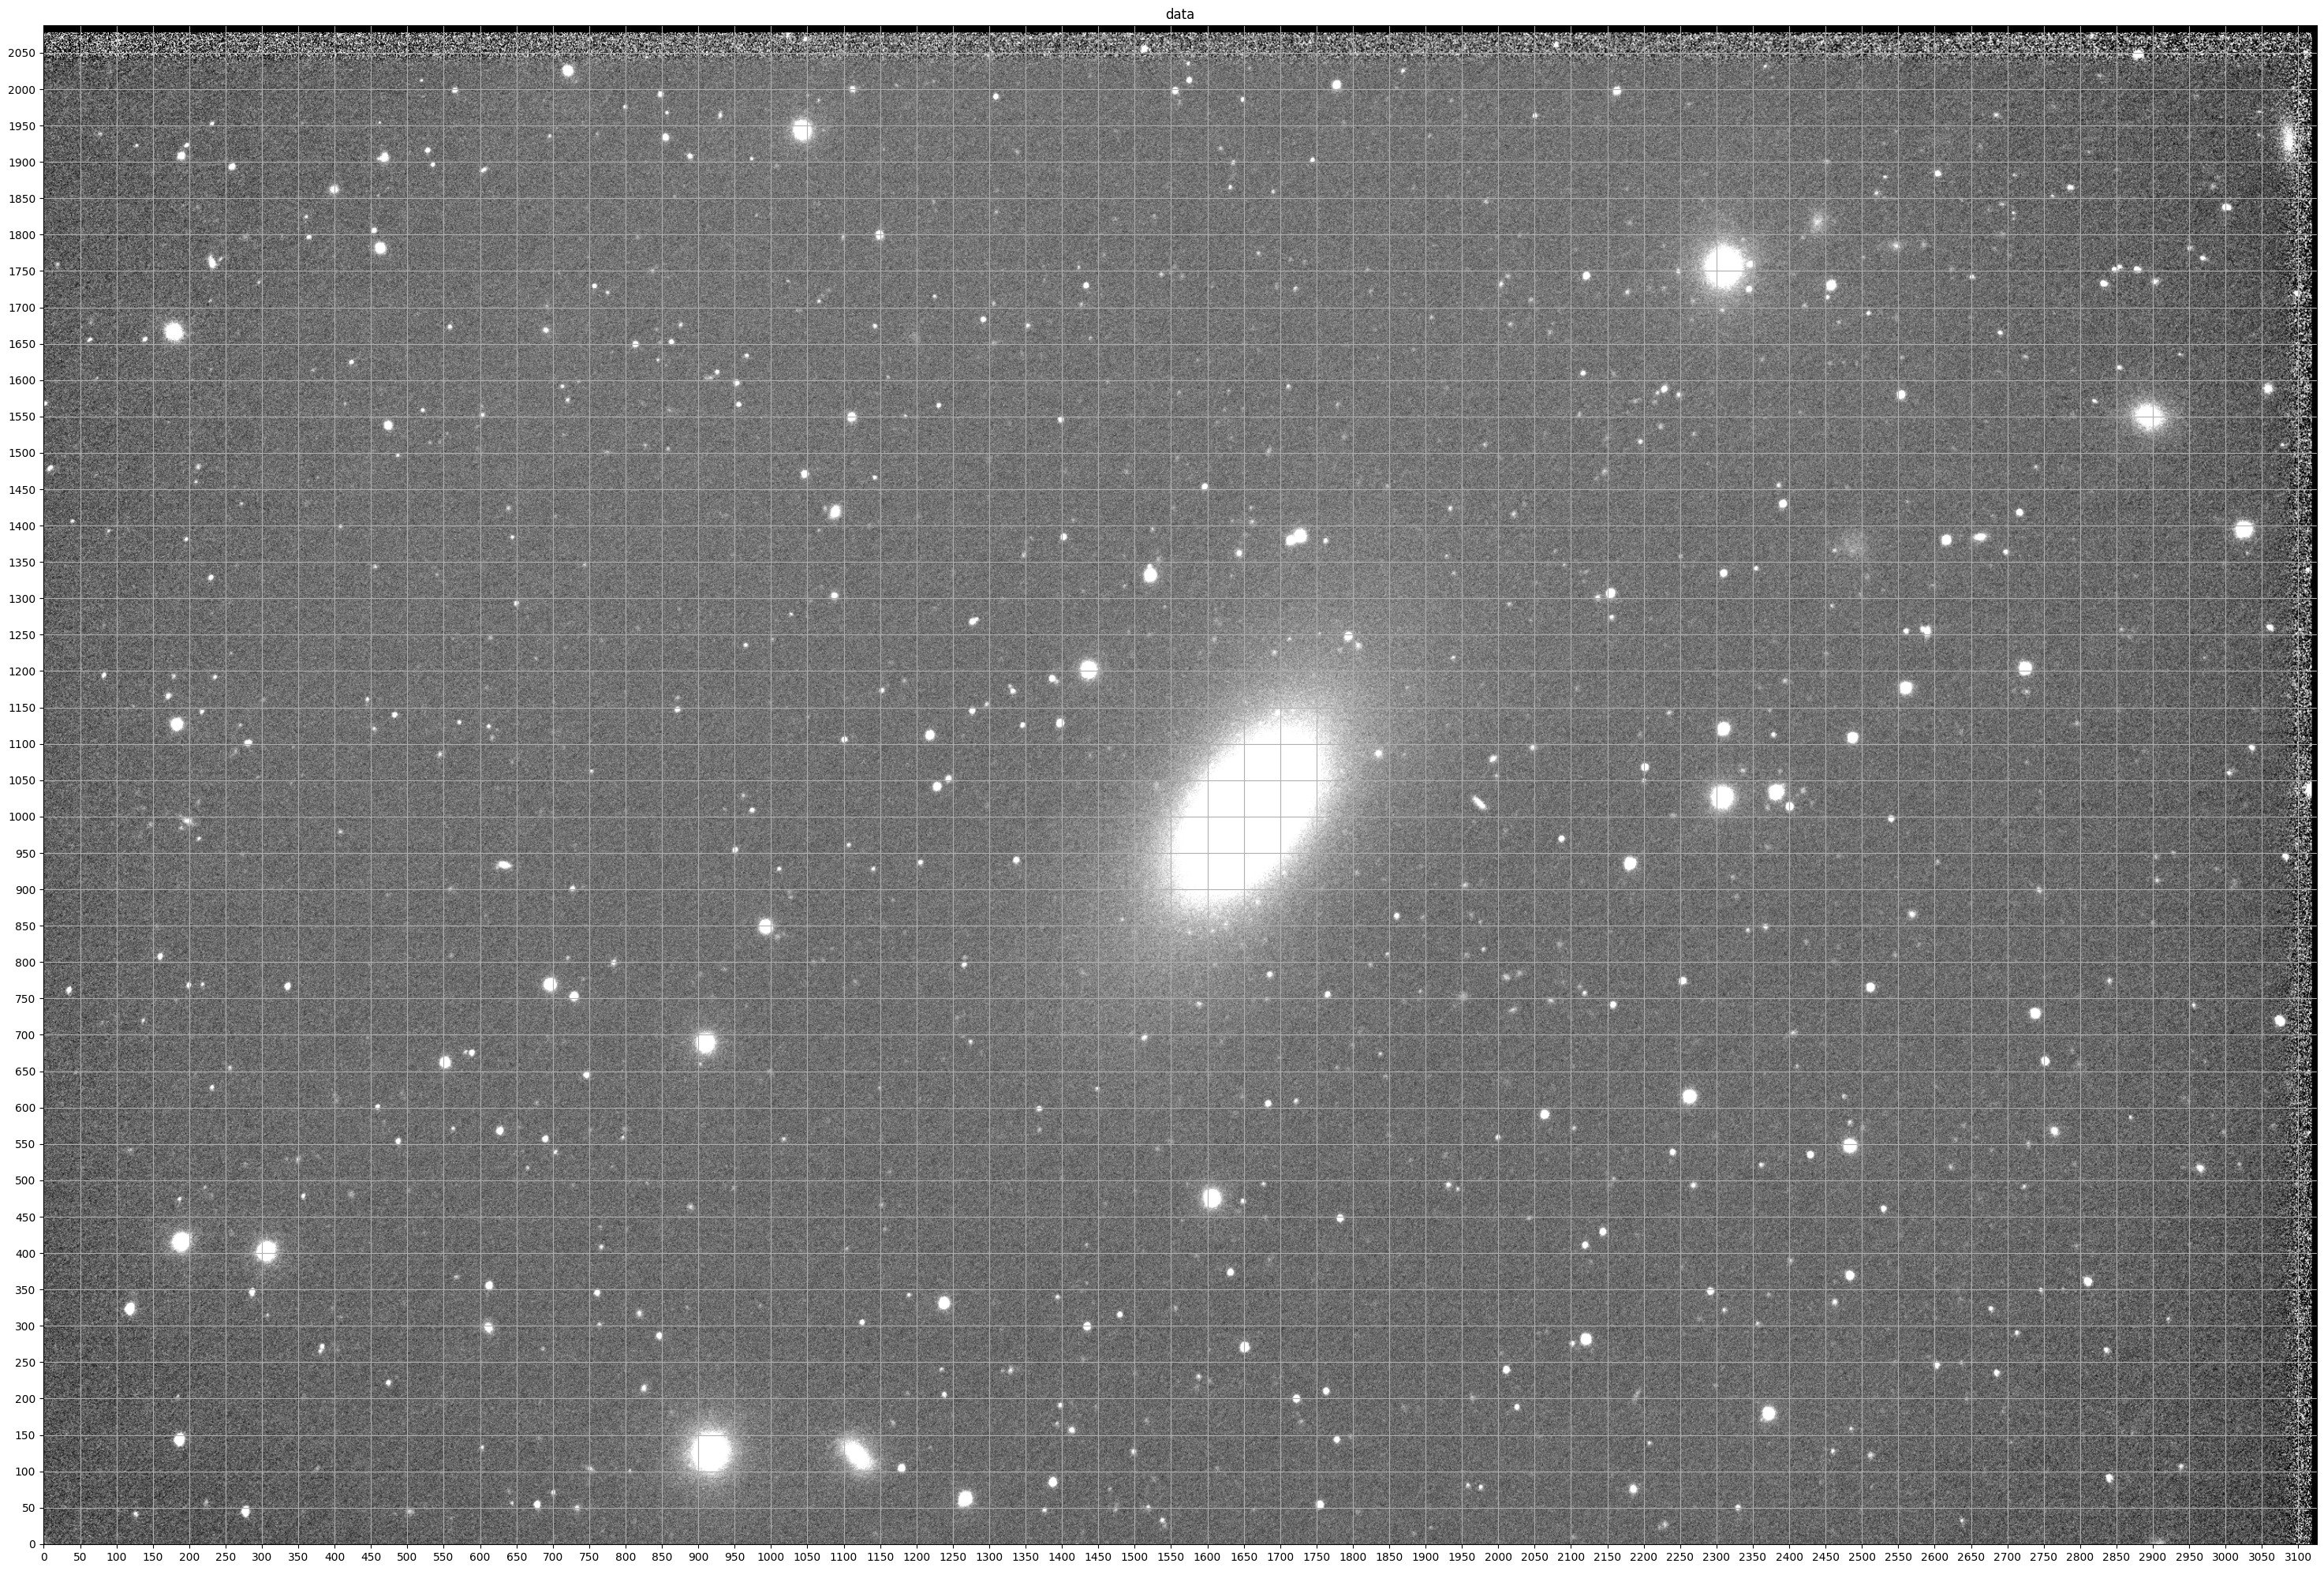

In [291]:
hdu = fits.open(f"./data/{file}_Siril_filled.fits")
data = hdu[0].data.astype(float)
hdu.close()

fig, ax = plt.subplots(1, 1, figsize=(50, 25))

ax.imshow(data, origin='lower', cmap='gray', vmin=np.percentile(data, 1), vmax=np.percentile(data, 99))
ax.set_title("data")
plt.xticks(range(0, data.shape[1], 50))
plt.yticks(range(0, data.shape[0], 50))
plt.tick_params()
plt.grid()

In [297]:
# NGC 1399
match file:
    case "NGC1399":
        centers = [[1760, 1390], [1340, 600], ]
        objects = ['NGC1404', 'NGC1399', ]

    case "NGC1407":
        centers = [[2050, 775], [1160, 1375], ]
        objects = ['NGC1407', 'NGC1400', ]

    case "NGC720":
        centers = [[1650, 1000], ]
        objects = ['NGC720', ]

background_value = np.median(data[1500:1510,1250:1260])

def fit_isophotes(center):
    print(f"fitting galaxy with center x0={center[0]}, y0={center[1]}")
    geometry = EllipseGeometry(
        x0=center[0], 
        y0=center[1],
        sma=50,
        eps=0.2,
        pa=3.14/2)

    ellipse = Ellipse(data, geometry=geometry)
    isolist = ellipse.fit_image()
    return isolist

def create_galaxy_model(isolist):
    model_image = build_ellipse_model(data.shape, isolist)
    return model_image

iso_lists = list(map(fit_isophotes, centers))
composite_model = reduce(lambda x, y: x + y , map(create_galaxy_model, iso_lists))
composite_model = np.where(composite_model == 0, background_value, composite_model)

fitting galaxy with center x0=1650, y0=1000


[]

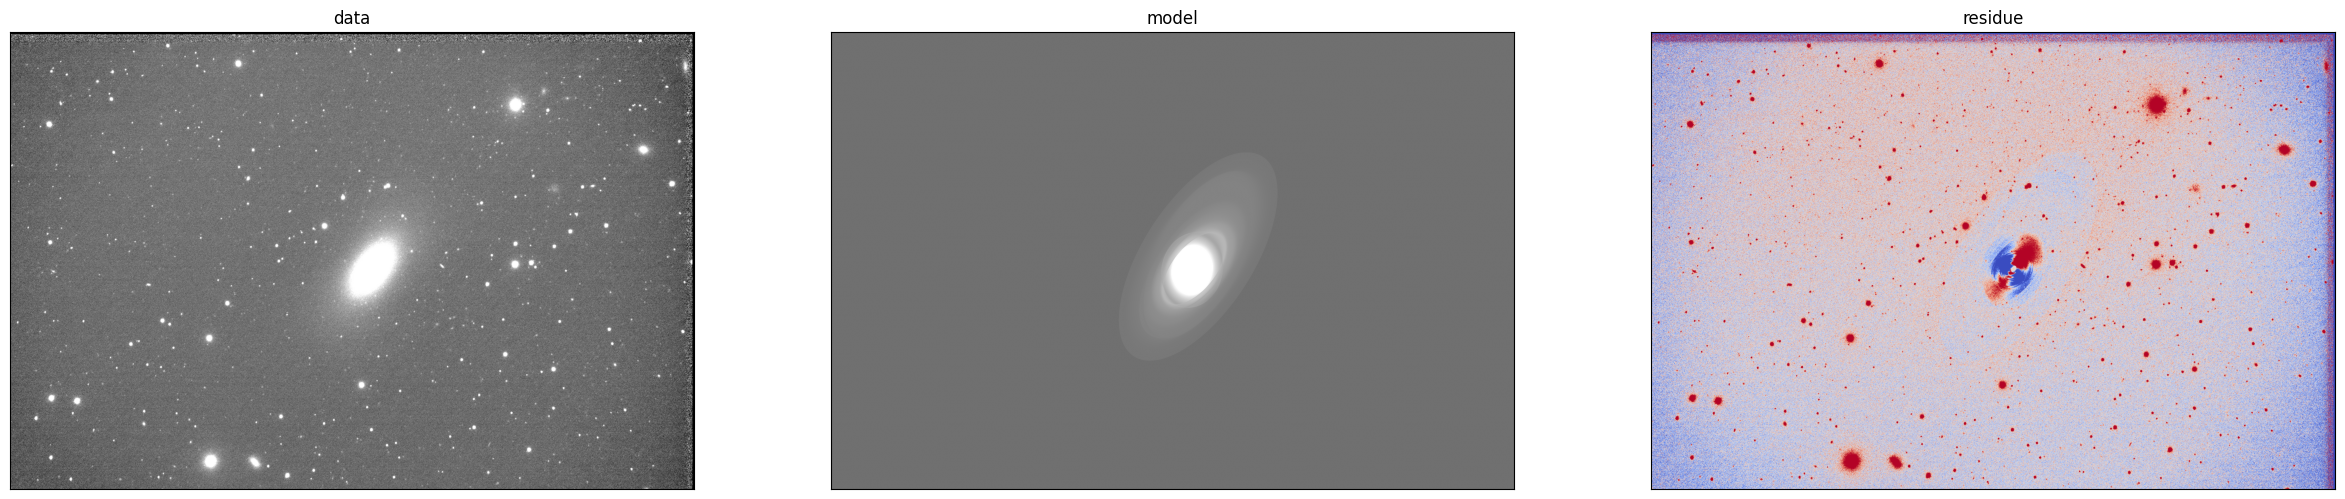

In [298]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

ax[0].imshow(data, origin='lower', cmap='gray', vmin=np.percentile(data, 1), vmax=np.percentile(data, 99))
ax[0].set_title("data")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(composite_model, origin='lower', cmap='gray', vmin=np.percentile(data, 1), vmax=np.percentile(data, 99))
ax[1].set_title("model")
ax[1].set_xticks([])
ax[1].set_yticks([])

residue_plot_range=0.05
ax[2].imshow((data - composite_model)/composite_model, origin='lower', cmap='coolwarm', vmin=-residue_plot_range, vmax=residue_plot_range)
ax[2].set_title("residue")
ax[2].set_xticks([])
ax[2].set_yticks([])

In [294]:
class SmoothedSersic1D(Fittable1DModel):
    amplitude = Parameter(default=1, description="Surface brightness at r_eff")
    r_eff = Parameter(default=1, description="Effective (half-light) radius")
    n = Parameter(default=4, description="Sersic index")
    sigma = Parameter(default=3, description="Sigma of the gaussian kernel")
    _gammaincinv = None

    def evaluate(cls, r, amplitude, r_eff, n, sigma):
        """One dimensional Sersic profile function."""
        if cls._gammaincinv is None:
            from scipy.special import gammaincinv

            cls._gammaincinv = gammaincinv

        res = amplitude * np.exp(
            -cls._gammaincinv(2 * n, 0.5) * ((r / r_eff) ** (1 / n) - 1))

        return gaussian_filter(res, sigma=sigma)

amp: Parameter('amplitude', value=0.011839321200885947), r_eff: Parameter('r_eff', value=6.1974857449700025), n: Parameter('n', value=0.09543129197151973), sigma: Parameter('sigma', value=9.99633268046879)


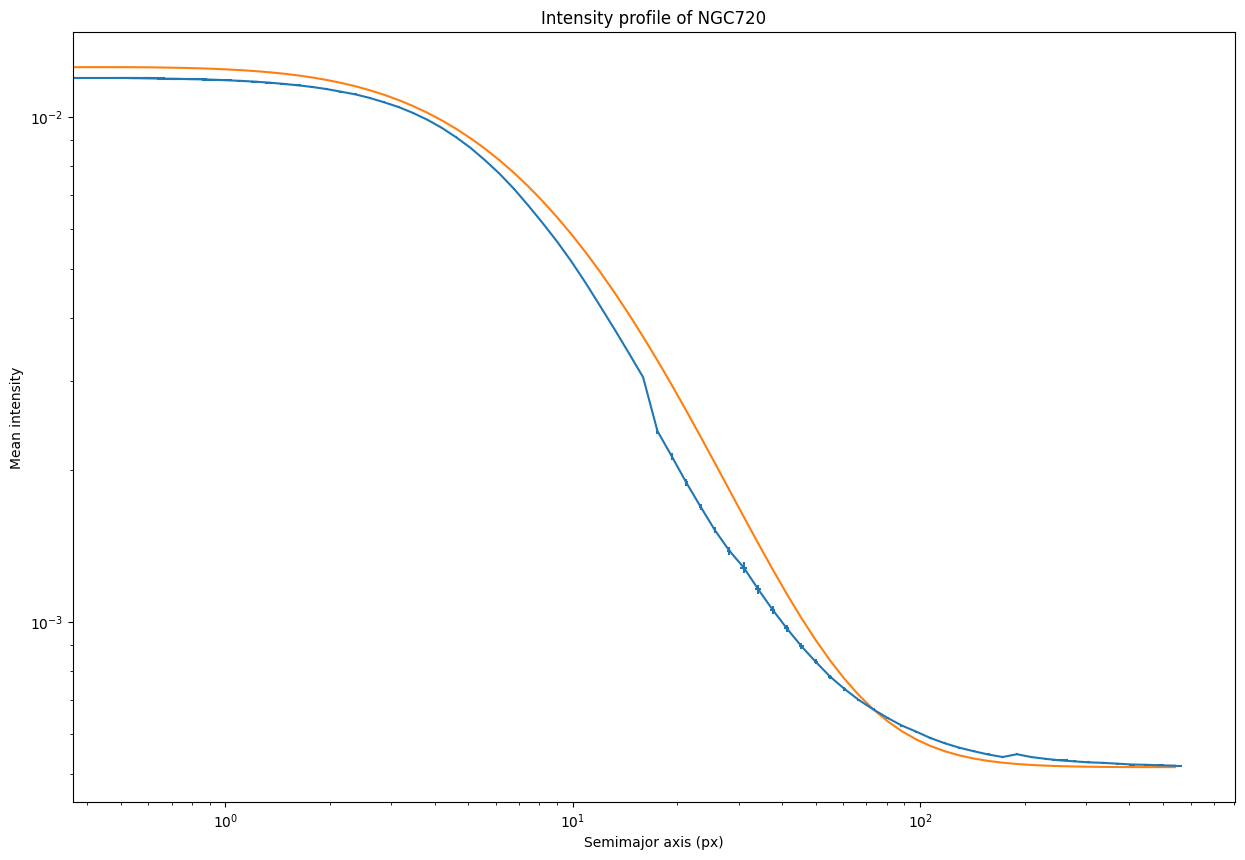

In [295]:
galaxy_count = len(iso_lists)

fig, ax = plt.subplots(1, galaxy_count, figsize=(15 * galaxy_count, 10))

# bruh I hate python
if galaxy_count == 1:
    ax = [ax]

for i in range(0, galaxy_count):
    y = list(map(lambda iso : iso.intens, iso_lists[i]))
    x = list(map(lambda iso : iso.sma, iso_lists[i]))
    
    yerr = list(map(lambda iso : iso.int_err, iso_lists[i]))
    xerr = list(map(lambda iso : iso.ellip_err * iso.sma, iso_lists[i]))

    model_init = SmoothedSersic1D(amplitude=5000, r_eff=12, n=0.9, sigma=3)
    fitter = fitting.LevMarLSQFitter()

    model_fit = fitter(model_init, x, y)

    print(f"amp: {model_fit.amplitude}, r_eff: {model_fit.r_eff}, n: {model_fit.n}, sigma: {model_fit.sigma}")

    ax[i].errorbar(x, y, yerr=yerr, xerr=xerr)
    ax[i].plot(x, model_fit(x) + background_value, label="fit")
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_title(f'Intensity profile of {objects[i]}')
    ax[i].set_xlabel('Semimajor axis (px)')
    ax[i].set_ylabel('Mean intensity')

TypeError: 'Axes' object is not subscriptable

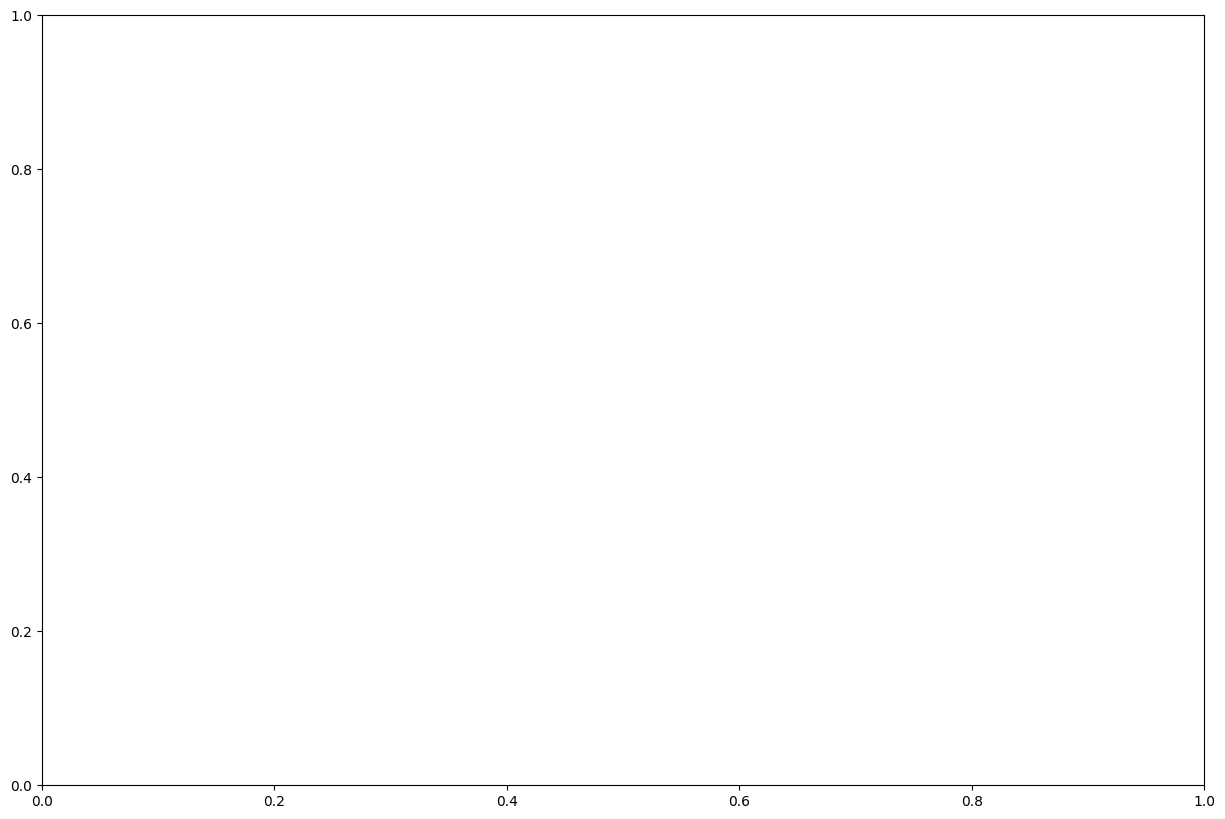

In [296]:
fig, ax = plt.subplots(1, galaxy_count, figsize=(15 * galaxy_count, 10))

for i in range(0, galaxy_count):
    y = list(map(lambda iso : iso.intens, iso_lists[i]))
    x = list(map(lambda iso : iso.sma, iso_lists[i]))

    ax[i].plot(x, y - (model_fit(x) + background_value), label="fit")
    ax[i].set_xscale('log')
    ax[i].set_title(f'Intensity profile of {objects[i]}')
    ax[i].set_xlabel('Semimajor axis (px)')
    ax[i].axhline(0)
    ax[i].set_ylabel('Residue')